## 1. Imports and data loading

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,\
mean_absolute_error, r2_score, mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [3]:
# Load dataset to df0

df0 = pd.read_csv('./data/2017_Yellow_Taxi_Trip_Data.csv')
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


## 2. EDA

In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

At a first glance there are some variables that are important to look at. Because this project is trying to do a prediction on the tips given by a customer, one can predict that the following variables will be involved:

- Fare amount
- Duration (can be calculated form pickup and dropoff times)
- Distance 
- Passenger count 

There may be other variables that influence tipping, but those will appear with further analysis.

In [5]:
# Convert data type of tpep_pickup_datetime and tpep_dropoff_datetime to datetime

df0['tpep_pickup_datetime'] = pd.to_datetime(df0['tpep_pickup_datetime'])
df0['tpep_dropoff_datetime'] = pd.to_datetime(df0['tpep_dropoff_datetime'])

df0['month'] = df0['tpep_pickup_datetime'].dt.month_name()
df0['day'] = df0['tpep_pickup_datetime'].dt.day_name()

In [6]:
# Create duration column

df0['duration'] = (df0['tpep_dropoff_datetime'] - df0['tpep_pickup_datetime'])/np.timedelta64(1,'m')

### 2.1 Visualizing the data

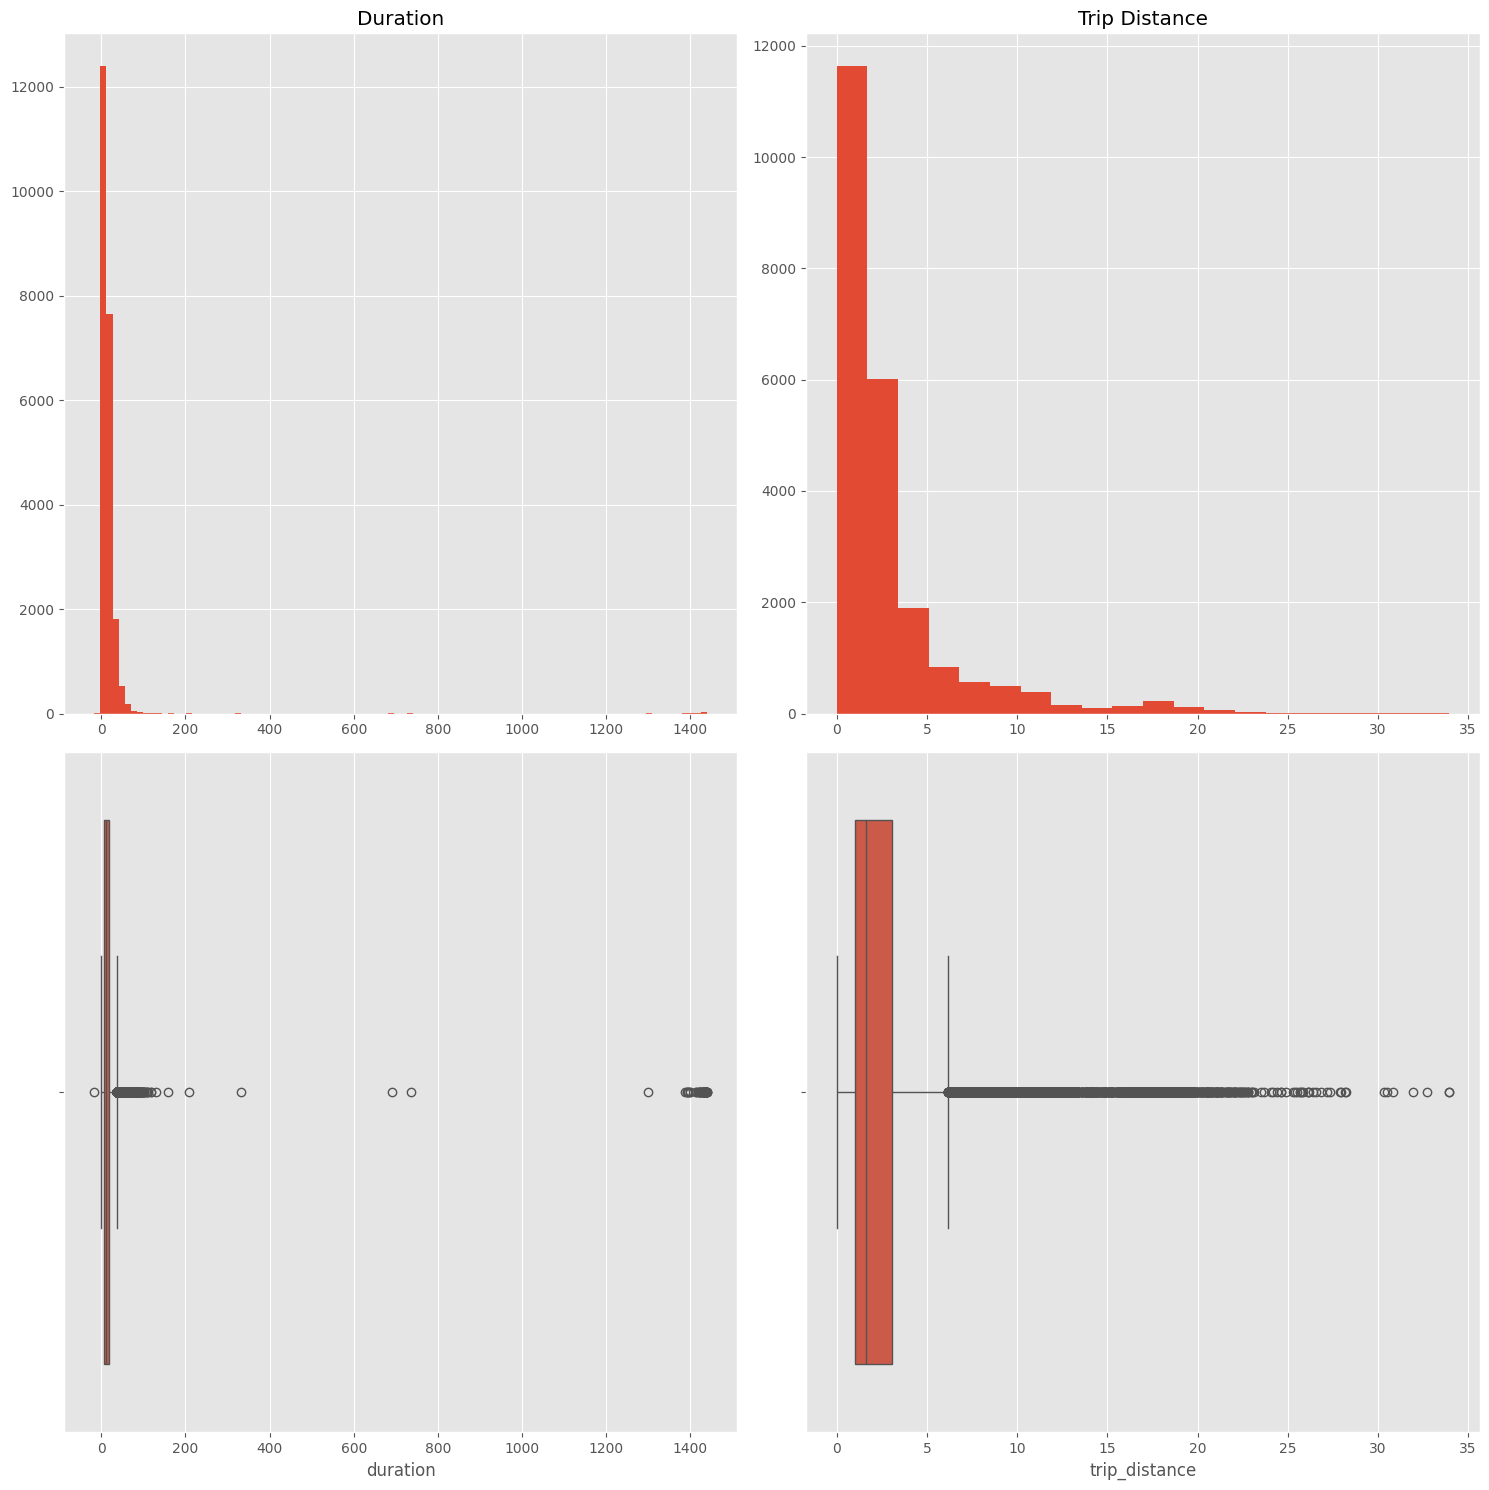

In [7]:
fig, ax = plt.subplots(2,2, figsize=(15,15))

ax[0,0].hist(df0.duration, bins=100)
ax[0,0].set_title('Duration')
ax[0,1].hist(df0.trip_distance, bins=20)
ax[0,1].set_title('Trip Distance')
sns.boxplot(x= df0.duration, ax=ax[1,0])
sns.boxplot(x=df0.trip_distance, ax=ax[1,1])

plt.tight_layout()
plt.show()


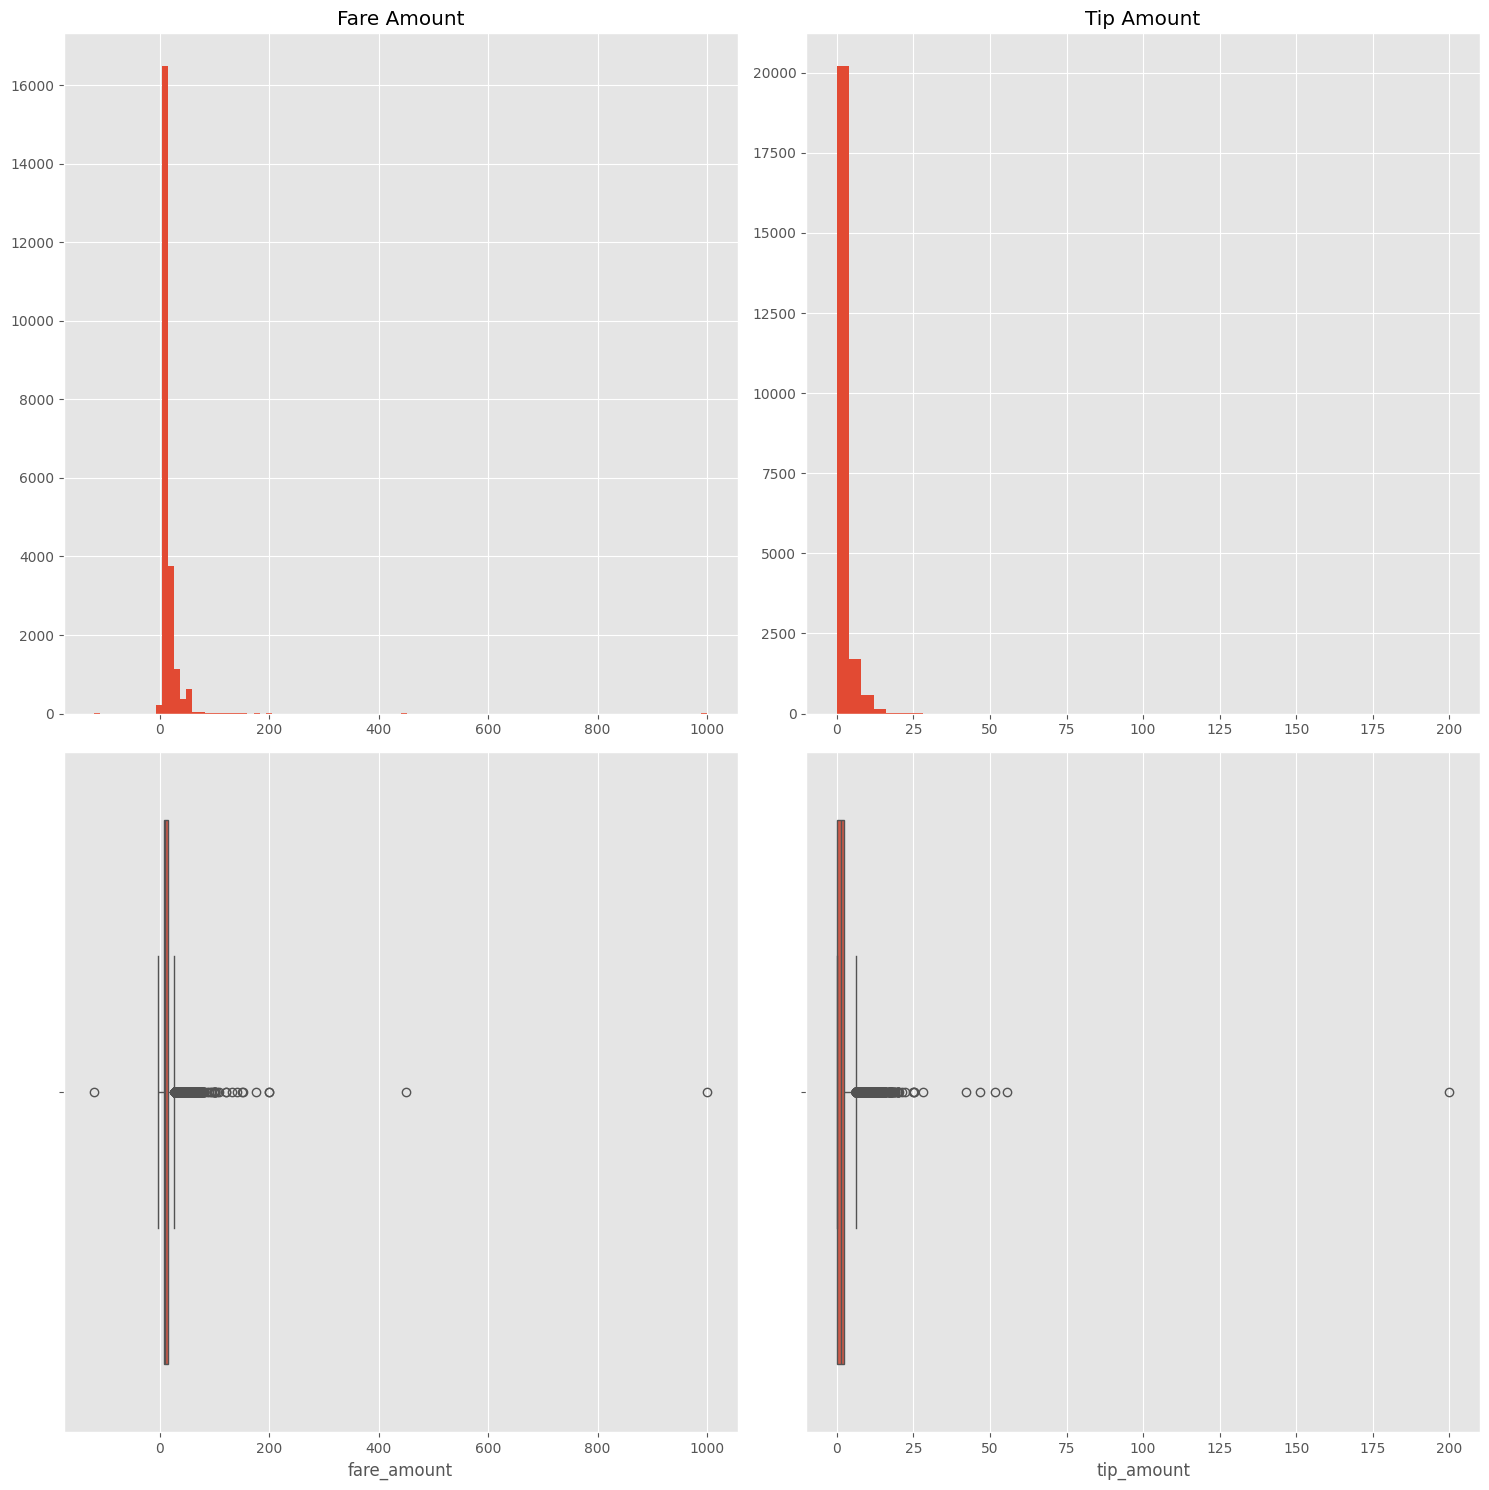

In [8]:
fig , ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].hist(df0.fare_amount, bins=100)
ax[0,0].set_title('Fare Amount')
ax[0,1].hist(df0.tip_amount, bins = 50)
ax[0,1].set_title('Tip Amount')
sns.boxplot(x= df0.fare_amount, ax=ax[1,0])
sns.boxplot(x=df0.tip_amount, ax=ax[1,1])
plt.tight_layout()
plt.show()

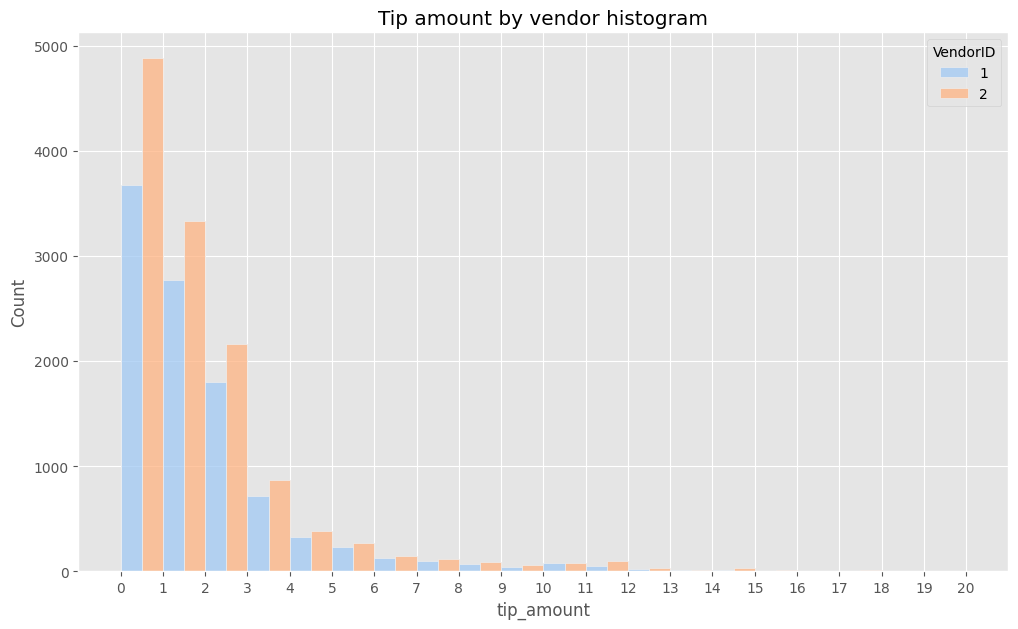

In [9]:
plt.figure(figsize=(12,7))
ax = sns.histplot(data=df0, x='tip_amount', bins=range(0,21,1), 
                  hue='VendorID', 
                  multiple='dodge',
                  palette='pastel')
ax.set_xticks(range(0,21,1))
ax.set_xticklabels(range(0,21,1))
plt.title('Tip amount by vendor histogram');

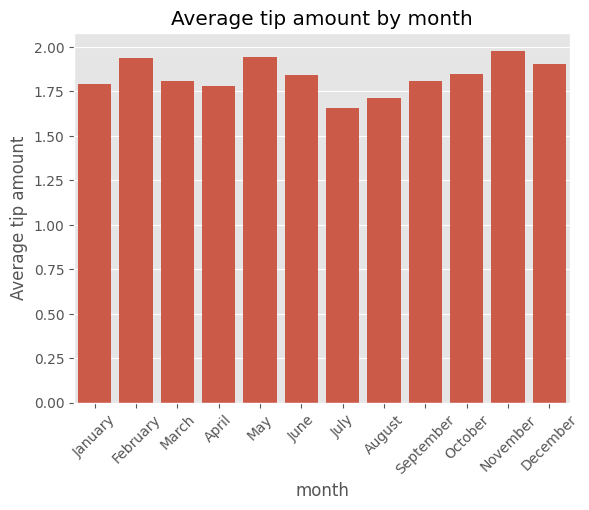

In [10]:
sns.barplot(df0.groupby('month').tip_amount.agg('mean'), order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.ylabel('Average tip amount')
plt.xticks(rotation=45)
plt.title('Average tip amount by month')
plt.show()


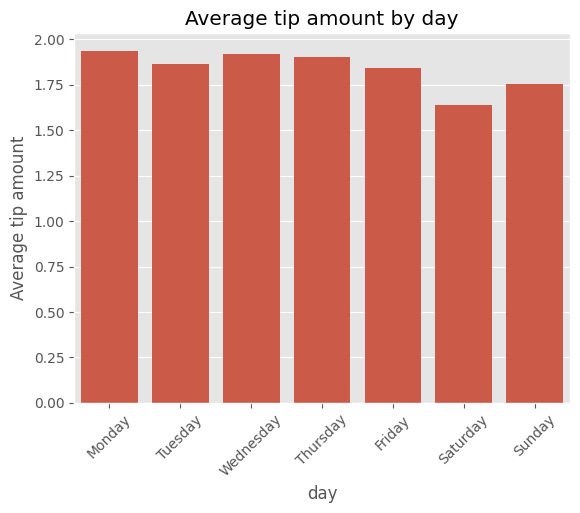

In [11]:
sns.barplot(df0.groupby('day').tip_amount.agg('mean'), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylabel('Average tip amount')
plt.xticks(rotation=45)
plt.title('Average tip amount by day')
plt.show()

## 3. Data Cleaning

Some of the variables have problematic values, for example, the duration or fare_amount can't be negative. In order to deal with this issue new values will be imputed for those variables.

In [12]:
def outlier_imputer(df, column_list, iqr_factor):
    """Contains the outliers of a given column within a 
    given by the iqr_factor.

    Args:
        df (DataFrame): Pandas DataFrame
        column_list (list): List of columns to iterate over
        iqr_factor (int): Factor that defines the range of the 
        new imputed values.
    """    
    for col in column_list:
        # Reassign minimum to zero
        df.loc[df[col] < 0, col] = 0

        # Calculate upper threshold
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        print(col)
        print('q3:', q3)
        print('upper_threshold:', upper_threshold)

        # Reassign values > threshold to threshold
        df.loc[df[col] > upper_threshold, col] = upper_threshold
        print(df[col].describe())
        print()

In [13]:
outlier_imputer(df0,
    [
        'duration',
        'fare_amount',
        'tip_amount',
        'trip_distance'
    ], 6
)

duration
q3: 18.383333333333333
upper_threshold: 88.78333333333333
count    22699.000000
mean        14.460555
std         11.947043
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: duration, dtype: float64

fare_amount
q3: 14.5
upper_threshold: 62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64

tip_amount
q3: 2.45
upper_threshold: 17.150000000000002
count    22699.000000
mean         1.818543
std          2.374812
min          0.000000
25%          0.000000
50%          1.350000
75%          2.450000
max         17.150000
Name: tip_amount, dtype: float64

trip_distance
q3: 3.06
upper_threshold: 15.480000000000002
count    22699.000000
mean         2.823424
std          3.252029
min          0.000000
25%          0.990000
50%          1.610000
75%          3

In [14]:
df0.groupby('payment_type')['tip_amount'].agg('mean')

payment_type
1    2.704167
2    0.000000
3    0.000000
4    0.000000
Name: tip_amount, dtype: float64

Only the credit card payment type has a non-zero tip average. For the rest of the analysis only credit card payment will be selected. 

In [15]:
df1 = df0[df0['payment_type'] == 1]

## 4. Feature Engineering

### 4.1 Mean distance and duration

Duration and trip distance have to be estimated before the fare starts. For this, two new features will be added: mean_distance and mean_duration. Using the labeling that the Taxi Company gives to each location is possible to estimate the mean distance between a a pair of locations. This will be calculated by grouping all the trips that share pickup and dropoff points and averaging their trip distances. The same can be done for the duration using the pickup and dropoff times. 

In [16]:
# Create a new column where with the pikcup-dropoff location pairs. 

df1['pickup_dropoff'] = df1['PULocationID'].astype(str)+ ' ' + df1['DOLocationID'].astype(str)
df1['pickup_dropoff'].head()

/tmp/ipykernel_38531/2151686462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['pickup_dropoff'] = df1['PULocationID'].astype(str)+ ' ' + df1['DOLocationID'].astype(str)


0    100 231
1     186 43
2    262 236
3     188 97
5    161 236
Name: pickup_dropoff, dtype: object

In [17]:
grouped = df1.groupby('pickup_dropoff').mean(numeric_only=True)[['trip_distance']]

grouped_dict = grouped.to_dict()

grouped_dict = grouped_dict['trip_distance']

In [18]:
df1['mean_distance'] = df1['pickup_dropoff'] 
df1['mean_distance'] = df1['mean_distance'].map(grouped_dict)
df1[(df1['PULocationID']==100) & (df1['DOLocationID']==231)][['mean_distance']]

/tmp/ipykernel_38531/511636126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mean_distance'] = df1['pickup_dropoff']
/tmp/ipykernel_38531/511636126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mean_distance'] = df1['mean_distance'].map(grouped_dict)


,mean_distance
0,3.2325
4909,3.2325
16636,3.2325
19761,3.2325


In [19]:
# Use the same process to calculate mean duration

grouped = df1.groupby('pickup_dropoff').mean(numeric_only=True)[['duration']]

grouped_dict = grouped.to_dict()
grouped_dict = grouped_dict['duration']

df1['mean_duration'] = df1['pickup_dropoff']
df1['mean_duration'] = df1['mean_duration'].map(grouped_dict)

/tmp/ipykernel_38531/593106049.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mean_duration'] = df1['pickup_dropoff']
/tmp/ipykernel_38531/593106049.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mean_duration'] = df1['mean_duration'].map(grouped_dict)


New variables will be created in order to classify the time of the day.

In [20]:
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

/tmp/ipykernel_38531/3796518631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour
/tmp/ipykernel_38531/3796518631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour
/tmp/ipykernel_38531/3796518631.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Now a function will be created to categorize each time of the day. 

In [21]:
def am_rush(hour):
    if hour['day'] == 'Saturday' or hour['day'] == 'Sunday':
        return 0
    elif 6 <= hour['am_rush'] < 10:
        return 1
    else:
        return 0
    
def daytime(hour):
    if hour['day'] == 'Saturday' or hour['day'] == 'Sunday':
        #Define weekend daytime as the 12 hours from 8am to 8pm  
        if 8 <= hour['daytime'] < 20:
            return 1
        else:
            return 0
    else:    
        if 10 <= hour['daytime'] < 17:
            return 1
        else:
            return 0
    
def pm_rush(hour):
    if hour['day'] == 'Saturday' or hour['day'] == 'Sunday':
        return 0
    elif 17 <= hour['pm_rush'] < 20:
        return 1
    else:
        return 0

def nighttime(hour):
    if hour['day'] == 'Saturday' or hour['day'] == 'Sunday':
        #Define weekend nighttime as the complementary twelve hours, from 8pm to 8am
        if not (8 <= hour['nighttime'] < 20):
            return 1
        else:
            return 0    
    else:
        if (20 <= hour['nighttime'] < 24) or (0 <= hour['nighttime'] < 6):
            return 1
        else:
            return 0

In [22]:
df1['daytime'] = df1.apply(daytime, axis=1)
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['pm_rush'] = df1.apply(pm_rush, axis=1)
df1['nighttime'] = df1.apply(nighttime, axis=1)

/tmp/ipykernel_38531/2887014716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['daytime'] = df1.apply(daytime, axis=1)
/tmp/ipykernel_38531/2887014716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['am_rush'] = df1.apply(am_rush, axis=1)


/tmp/ipykernel_38531/2887014716.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['pm_rush'] = df1.apply(pm_rush, axis=1)
/tmp/ipykernel_38531/2887014716.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['nighttime'] = df1.apply(nighttime, axis=1)


### 4.2 Fare Amount Prediction

With this new features a multiple linear regression model will be trained in order to predict the total fare. This will be later used as to train the model that identifies generous customers. 

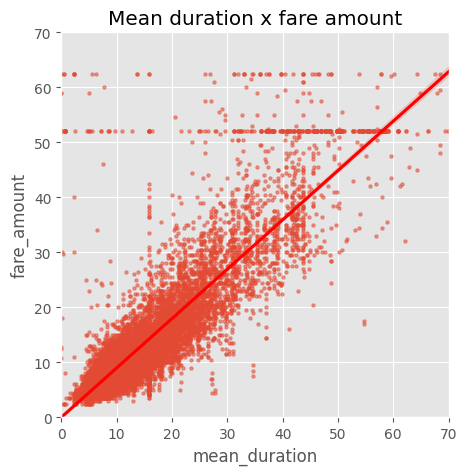

In [23]:

f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)
sns.regplot(x=df1['mean_duration'], y=df1['fare_amount'],
            scatter_kws={'alpha':0.5, 's':5},
            line_kws={'color':'red'})
plt.ylim(0, 70)
plt.xlim(0, 70)
plt.title('Mean duration x fare amount')
plt.show()

The previous scatterplot shows a strong correlation between the mena duration of a trip and its fare. It is possible to observe two horizontal lines right above $50 and $60. This phenomena could be caused by a standard fare applied to certain trips like ariport rides. In this case the fare doesn't depend on the duration but on the endpoints of the trip. We'll look into this issue and how to deal with it. 

In [24]:
df1[df1['fare_amount'] >50]['fare_amount'].value_counts().head()

fare_amount
52.0    368
62.5     56
59.0      8
50.5      8
55.0      6
Name: count, dtype: int64

In [25]:
df1[df1['fare_amount'] == 52.0].head(15)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month,day,duration,pickup_dropoff,mean_distance,mean_duration,am_rush,daytime,pm_rush,nighttime
11,18600059,2,2017-03-05 19:15:30,2017-03-05 19:52:18,2,15.48,2,N,236,132,1,52.0,0.0,0.5,14.58,5.54,0.3,72.92,March,Sunday,36.800000,236 132,15.480000,42.753333,0,1,0,0
110,47959795,1,2017-06-03 14:24:57,2017-06-03 15:31:48,1,15.48,2,N,132,163,1,52.0,0.0,0.5,0.00,0.00,0.3,52.80,June,Saturday,66.850000,132 163,15.480000,55.559524,0,1,0,0
379,80479432,2,2017-09-24 23:45:45,2017-09-25 00:15:14,1,15.48,2,N,132,234,1,52.0,0.0,0.5,14.64,5.76,0.3,73.20,September,Sunday,29.483333,132 234,15.480000,49.833333,0,0,0,1
520,33706214,2,2017-04-23 21:34:48,2017-04-23 22:46:23,6,15.48,2,N,132,148,1,52.0,0.0,0.5,5.00,0.00,0.3,57.80,April,Sunday,71.583333,132 148,15.480000,44.520000,0,0,0,1
569,99259872,2,2017-11-22 21:31:32,2017-11-22 22:00:25,1,15.48,2,N,132,144,1,52.0,0.0,0.5,10.56,0.00,0.3,63.36,November,Wednesday,28.883333,132 144,15.480000,37.000000,0,0,0,1
572,61050418,2,2017-07-18 13:29:06,2017-07-18 13:29:19,1,0.00,2,N,230,161,1,52.0,0.0,0.5,11.71,5.76,0.3,70.27,July,Tuesday,0.216667,230 161,0.672105,8.598246,0,1,0,0
586,54444647,2,2017-06-26 13:39:12,2017-06-26 14:34:54,1,15.48,2,N,211,132,1,52.0,0.0,0.5,11.71,5.76,0.3,70.27,June,Monday,55.700000,211 132,15.480000,55.700000,0,1,0,0
692,94424289,2,2017-11-07 22:15:00,2017-11-07 22:45:32,2,15.48,2,N,132,170,1,52.0,0.0,0.5,11.71,5.76,0.3,70.27,November,Tuesday,30.533333,132 170,15.480000,38.211111,0,0,0,1
717,103094220,1,2017-12-06 05:19:50,2017-12-06 05:53:52,1,15.48,2,N,132,239,1,52.0,0.0,0.5,5.85,5.76,0.3,64.41,December,Wednesday,34.033333,132 239,15.480000,32.533333,0,0,0,1
719,66115834,1,2017-08-04 17:53:34,2017-08-04 18:50:56,1,15.48,2,N,264,264,1,52.0,4.5,0.5,12.60,5.76,0.3,75.66,August,Friday,57.366667,264 264,3.033785,15.928343,0,0,1,0


Some patterns start to arise when looking at the data corresponding to $52 trips. Most of them include the location id 132 either as pick up or drop off point. In the shown sample all of the observations have a RatecodeID of 2. Looking into the data dictionary we can see that that value corresponds to taxi rides to and from the JFK airport in Queens. This values could be later imputed to minimize error. 

Not all of the variables are important for this regression model. In the next step a reduced data set will be created to ease the computation. 

In [26]:
df1a = df1.copy()

df1a = df1a.drop([
    'Unnamed: 0',
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime',
    'trip_distance',
    'RatecodeID',
    'store_and_fwd_flag',
    'PULocationID',
    'DOLocationID',
    'payment_type',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'improvement_surcharge',
    'total_amount',
    'duration',
    'pickup_dropoff',
    'day',
    'month'   
    ], axis=1)

df1a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   fare_amount      15265 non-null  float64
 3   mean_distance    15265 non-null  float64
 4   mean_duration    15265 non-null  float64
 5   am_rush          15265 non-null  int64  
 6   daytime          15265 non-null  int64  
 7   pm_rush          15265 non-null  int64  
 8   nighttime        15265 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 1.2 MB


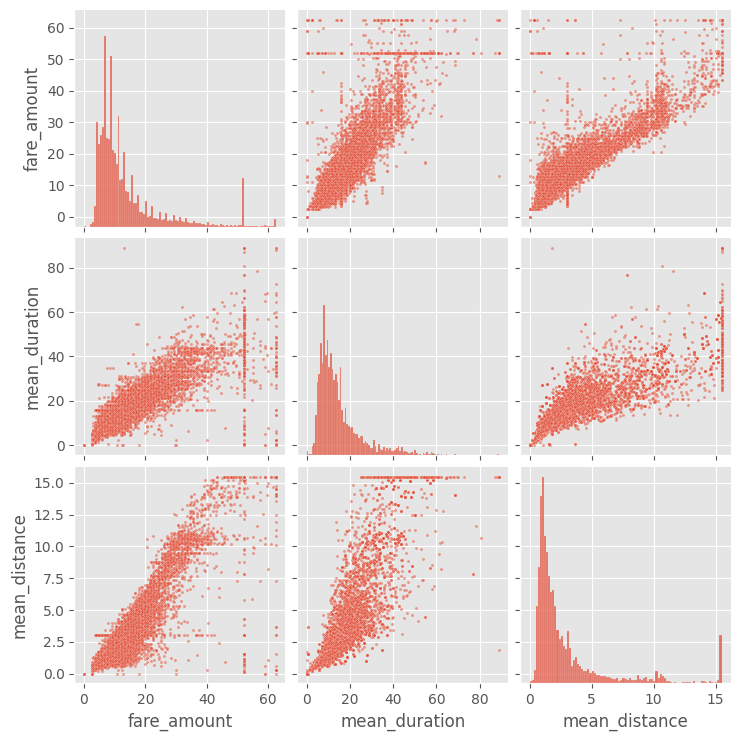

In [27]:
sns.pairplot(df1a[['fare_amount', 'mean_duration', 'mean_distance']],
             plot_kws={'alpha':0.5, 's':5})

There is a clear linear relationship between the continuous variables, the next table shows the multicollinearity of the data set. 

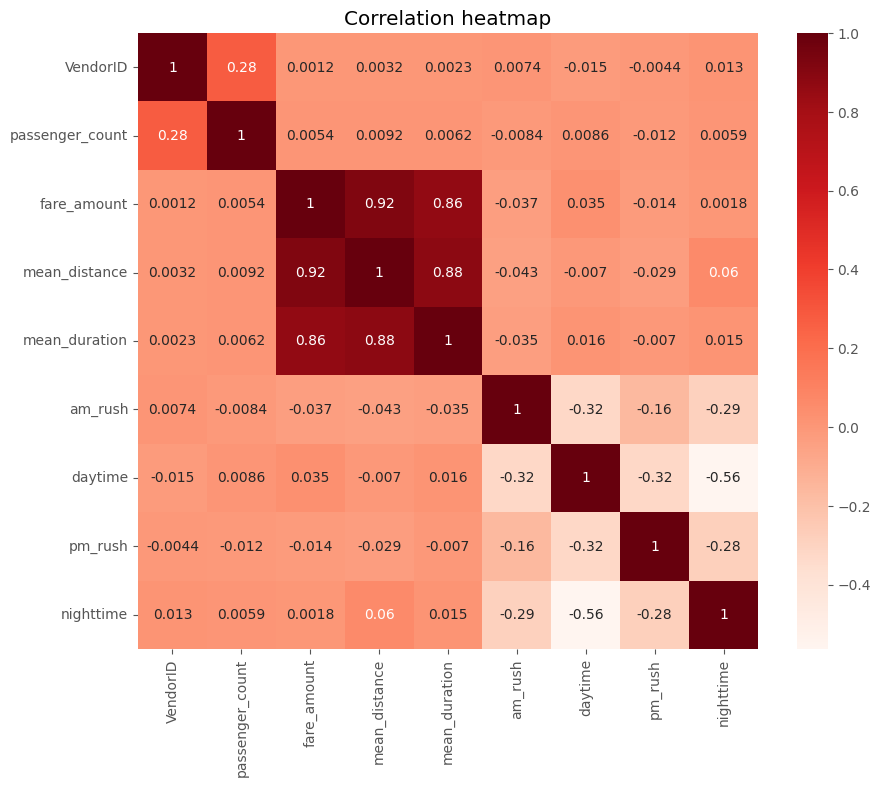

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(df1a.corr(method='pearson'), annot=True, cmap='Reds')
plt.title('Correlation heatmap')
plt.show()

#### 4.2.1. Model Construction

In [29]:
X = df1a.drop('fare_amount', axis=1)
y = df1a[['fare_amount']]

Then categorical variable have to be encoded as a dummy variable. 

In [30]:
X['VendorID'] = X['VendorID'].astype(str)
X = pd.get_dummies(X, drop_first=True, dtype=int)
X.head()

,passenger_count,mean_distance,mean_duration,am_rush,daytime,pm_rush,nighttime,VendorID_2
0,6,3.232500,16.225000,0,1,0,0,1
1,1,3.362500,24.450000,0,1,0,0,0
2,1,0.887619,7.116667,1,0,0,0,0
3,1,3.700000,30.250000,0,1,0,0,1
5,6,1.986087,11.760145,0,0,0,1,1


Training and testing sets are also to be created.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

And standarized using the StandardScaler.

In [32]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

With the variables processed is time to fit the model and evaluate the results. 

In [33]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

#### 4.2.2. Model Evaluation

In [34]:
r_sq = lr.score(X_train_scaled, y_train)
print('Coefficient of determination:', r_sq)
y_pred_train = lr.predict(X_train_scaled)
print('R^2:', r2_score(y_train, y_pred_train))
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

Coefficient of determination: 0.8568672491489053
R^2: 0.8568672491489053
MAE: 2.0940273520552886
MSE: 16.48679246345544
RMSE: 4.060393141489558


And the same thing for the test data

In [35]:
X_test_scaled = scaler.transform(X_test)
r_sq_test = lr.score(X_test_scaled, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = lr.predict(X_test_scaled)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination: 0.8405552770496589
R^2: 0.8405552770496589
MAE: 2.050679105524134
MSE: 17.279830367064484
RMSE: 4.156901534444192


This multiple regression model accounts for ~84% of the variance in the `fare_amountp` variable. It isn't perfect, but it gives a rough estimation that would be useful for the purpose of this project. 

Both R^2 values for the train and test sets are very close, this means that the regression is not overfitting the training data. The next step is to plot the results to further understand how the regression performs on the data. 

For convenience a new dataframe with the results and residual will be created. 

In [36]:
results = pd.DataFrame(data={
    'actual': y_test['fare_amount'], 
    'predicted': y_pred_test.ravel()
    })
results['residual'] = results.actual - results.predicted

Text(0.5, 1.0, 'Distribution of residuals')

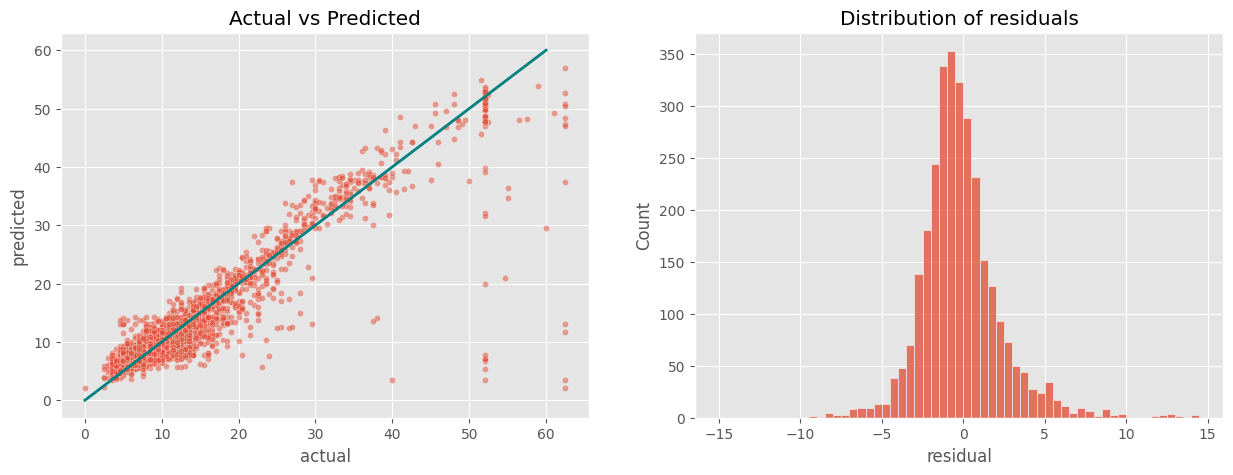

In [37]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.scatterplot(
    data = results,
    x='actual',
    y='predicted',
    s=20,
    alpha=0.5,
    ax=ax[0]
)
ax[0].plot([0,60],[0,60],c='teal', linewidth=2)
ax[0].set_title('Actual vs Predicted')

sns.histplot(results['residual'], bins=np.arange(-15,15,0.5), ax=ax[1])
ax[1].set_title('Distribution of residuals')

The residuals follow a quasi-normal distribution meaning that there isn't any notable bias, and prediction errors are random in nature. 

For the sake of understanding the regression model, let's take a look at the coefficients. 

In [38]:
coefficients = pd.DataFrame(lr.coef_, columns=X.columns)
coefficients

,passenger_count,mean_distance,mean_duration,am_rush,daytime,pm_rush,nighttime,VendorID_2
0,-0.043927,7.766577,2.39685,0.01223,0.238439,0.085794,-0.319141,-0.037817


The biggest contribution to `fare_amount` seem to be coming from `mean_distance` and `mean_duration`. One has to remind that the data has been scaled in a previous step before extracting conclusions from these coefficients. Taking that into account, for every one standard deviation increase in `mean_distance` the fare amount increases by $7.76. Every increase of one standard deviation in `mean_duration` the fare increases by $2.40. A simple calculation will give the dollars/mile and dollars/minute ratios.

In [39]:
print(7.766577 / X_train['mean_distance'].std(),'$/mile')
print(2.39685 / X_train['mean_duration'].std(),'$/minute')

2.3764224133134735 $/mile
0.23275794666510305 $/minute


#### 4.2.3. Predicting on the full dataset

Using the `scaler` and the `lr` model from the previous epigraph, let's predict the full dataset.

In [40]:
X_scaled = scaler.transform(X)
y_preds_full = lr.predict(X_scaled)

Now let's take some steps to impute all the predictions for `RatecodeID` = 2 with the airport fare rate $52

In [41]:
final_preds = df1[['RatecodeID']].copy()

final_preds['y_preds_full'] = y_preds_full

final_preds.loc[final_preds['RatecodeID']==2, 'y_preds_full'] = 52

final_preds[final_preds['RatecodeID']==2].head()

,RatecodeID,y_preds_full
11,2,52.0
110,2,52.0
379,2,52.0
520,2,52.0
569,2,52.0


To finish with this step, we'll check the performance on the full dataset. 

In [42]:
final_preds = final_preds['y_preds_full']
print('R^2:', r2_score(y, final_preds))
print('MAE:', mean_absolute_error(y, final_preds))
print('MSE:', mean_squared_error(y, final_preds))
print('RMSE:', np.sqrt(mean_squared_error(y, final_preds)))

R^2: 0.894761298247789
MAE: 1.9324957916631333
MSE: 11.978864159599194
RMSE: 3.461049574854309


There has been an increase in the accuracy of the model. Now 89.48% of the variance is explained by the regression model. The column `y_preds_full` is to be added to the data set under the name `predicted_fare`.

In [43]:
df2 = df1.copy()
df2['predicted_fare'] = final_preds
df2.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month,day,duration,pickup_dropoff,mean_distance,mean_duration,am_rush,daytime,pm_rush,nighttime,predicted_fare
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,March,Saturday,14.066667,100 231,3.232500,16.225000,0,1,0,0,14.573892
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,April,Tuesday,26.500000,186 43,3.362500,24.450000,0,1,0,0,17.046184
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,December,Friday,7.200000,262 236,0.887619,7.116667,1,0,0,0,6.676257
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,May,Sunday,30.250000,188 97,3.700000,30.250000,0,1,0,0,19.122175
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,March,Saturday,8.000000,161 236,1.986087,11.760145,0,0,0,1,9.405180


### 4.3 Identifying generous customers 

The goal of this project is to predict whether the customer will be  *generous* or not. It is important to note that this classification is subjective and by no means tries to be a judgment of character for the customers. The threshold set is arbitrary and can be changed. For this purpose a new binary variable will be created measuring if the tip exceeds 20% of the total fare.

In [44]:
df2['tip_percent'] = round(df2['tip_amount'] / (df2['total_amount'] - df2['tip_amount']), 3)

In [45]:
df2['generous'] = df2['tip_percent']
df2['generous'] = (df2['generous'] >= 0.2).astype(int)

In [46]:
df2.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month,day,duration,pickup_dropoff,mean_distance,mean_duration,am_rush,daytime,pm_rush,nighttime,predicted_fare,tip_percent,generous
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,March,Saturday,14.066667,100 231,3.232500,16.225000,0,1,0,0,14.573892,0.200,1
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,April,Tuesday,26.500000,186 43,3.362500,24.450000,0,1,0,0,17.046184,0.238,1
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,December,Friday,7.200000,262 236,0.887619,7.116667,1,0,0,0,6.676257,0.199,0
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,May,Sunday,30.250000,188 97,3.700000,30.250000,0,1,0,0,19.122175,0.300,1
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,March,Saturday,8.000000,161 236,1.986087,11.760145,0,0,0,1,9.405180,0.200,1


Once all this new features have been added to the data set, it is time to drop unnecessary columns.

### 4.4 Drop columns and variable enconding

In [47]:
drop_cols = [
    'Unnamed: 0',
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime',
    'trip_distance',
    'store_and_fwd_flag',
    'payment_type',
    'fare_amount',
    'tip_amount',
    'extra',
    'mta_tax',
    'tolls_amount',
    'improvement_surcharge',
    'total_amount',
    'tip_percent',
    'pickup_dropoff',
    'duration'
]

df2 = df2.drop(drop_cols, axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   month            15265 non-null  object 
 6   day              15265 non-null  object 
 7   mean_distance    15265 non-null  float64
 8   mean_duration    15265 non-null  float64
 9   am_rush          15265 non-null  int64  
 10  daytime          15265 non-null  int64  
 11  pm_rush          15265 non-null  int64  
 12  nighttime        15265 non-null  int64  
 13  predicted_fare   15265 non-null  float64
 14  generous         15265 non-null  int64  
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


In [48]:
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

for col in cols_to_str:
    df2[col] = df2[col].astype(str)

In [49]:
df3 = pd.get_dummies(df2, drop_first=True)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to day_Wednesday
dtypes: bool(338), float64(3), int64(6)
memory usage: 6.1 MB


### 4.5 Choosing an evaluation metric

The target variable `generous` is to be studied in order to choosed the most appropriate metric to evaluate the model.  

In [50]:
df3.generous.value_counts(normalize=True)

generous
1    0.525319
0    0.474681
Name: proportion, dtype: float64

This result means that roughly half of the customers give a tip ≥ 20%, in other words, the dataset is balanced. 

For the evaluation metric is interesting to explore the possibilities of error:

- **False positives:** the model identifies a customer as *generous* increasing the chances that a driver will pick them up, but they don't fulfill the predicted tipping expectations.
- **False negatives:** the model fails to identify a customer as *generous* decreasing the likelyhood that a driver will pick them up and, therefore the chances of being tipped satisfactorily.

Having this in mind, and knowing that this model attempts to be equanimous in both ends one should't try to minimize one kind of errors more than the other and so **F<sub>1</sub>** score is the most appropriate. 